In [1]:
import torch

In [2]:
model_path = '../models/rnn_seq2seq.pt'

In [3]:
### Select device (GPU) ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


print('Selected device:', device)

Selected device: cuda


In [4]:
import pandas as pd

### Reading data set ###

df = pd.read_csv('../data-sets/eng-nld.txt', sep='\t', header=None, usecols=[0, 1], names=['ENG', 'NLD'], dtype='string')
df.dropna()


print(df.info())
print()
print(df.sample())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76224 entries, 0 to 76223
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ENG     76224 non-null  string
 1   NLD     76224 non-null  string
dtypes: string(2)
memory usage: 1.2 MB
None

                  ENG                  NLD
5675  We're painters.  Wij zijn schilders.


In [5]:
import numpy as np
from nltk import word_tokenize

### Preprocessing ###

train_frac = 0.8
max_size = 15

sos_token = "<sos>"
eos_token = "<eos>"


# Tokenize
df['eng_tokens'] = df['ENG'].apply(lambda x: [sos_token] + word_tokenize(x.lower()) + [eos_token])
df['nld_tokens'] = df['NLD'].apply(lambda x: [sos_token] + word_tokenize(x.lower()) + [eos_token])

# Trim
df = df.drop(df[
    (df['eng_tokens'].map(len) > max_size) | 
    (df['nld_tokens'].map(len) > max_size)
].index)

# Split
df = df.sample(frac=1).reset_index(drop=True)
split = int(train_frac * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)


print('Total rows from file:', len(df))
print('Total rows of train data::', len(train_data))
train_data

Total rows from file: 74266
Total rows of train data:: 59412


,ENG,NLD,eng_tokens,nld_tokens
0,Ask Tom where he lives.,Vraag Tom waar hij woont.,"[<sos>, ask, tom, where, he, lives, ., <eos>]","[<sos>, vraag, tom, waar, hij, woont, ., <eos>]"
1,Rest in peace.,Rust in vrede.,"[<sos>, rest, in, peace, ., <eos>]","[<sos>, rust, in, vrede, ., <eos>]"
2,Tom understands French.,Tom verstaat Frans.,"[<sos>, tom, understands, french, ., <eos>]","[<sos>, tom, verstaat, frans, ., <eos>]"
3,Who talked?,Wie praatte er?,"[<sos>, who, talked, ?, <eos>]","[<sos>, wie, praatte, er, ?, <eos>]"
4,My father takes a bath before supper.,Mijn vader neemt een bad voor het eten.,"[<sos>, my, father, takes, a, bath, before, su...","[<sos>, mijn, vader, neemt, een, bad, voor, he..."
...,...,...,...,...
59407,Aren't you guys still dating?,Zijn jullie niet meer samen?,"[<sos>, are, n't, you, guys, still, dating, ?,...","[<sos>, zijn, jullie, niet, meer, samen, ?, <e..."
59408,You don't need to stand up.,Je hoeft niet op te staan.,"[<sos>, you, do, n't, need, to, stand, up, ., ...","[<sos>, je, hoeft, niet, op, te, staan, ., <eos>]"
59409,I'm on my way home from work.,Ik ben op weg naar huis van het werk.,"[<sos>, i, 'm, on, my, way, home, from, work, ...","[<sos>, ik, ben, op, weg, naar, huis, van, het..."
59410,The students burned their textbooks.,De studenten hebben hun schoolboeken verbrand.,"[<sos>, the, students, burned, their, textbook...","[<sos>, de, studenten, hebben, hun, schoolboek..."


In [6]:
import torchtext

min_freq  = 2
unk_token = '<unk>'
pad_token = '<pad>'

special_tokens = [unk_token, pad_token, sos_token, eos_token]


eng_vocab = torchtext.vocab.build_vocab_from_iterator(
    df['eng_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)


nld_vocab = torchtext.vocab.build_vocab_from_iterator(
    df['nld_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

eng_vocab.set_default_index(eng_vocab[unk_token])
nld_vocab.set_default_index(nld_vocab[unk_token])


print('Unique tokens in \'eng_tokens\' column:', len(eng_vocab))
print('Unique tokens in \'nld_tokens\' column:', len(nld_vocab))

Unique tokens in 'eng_tokens' column: 6566
Unique tokens in 'nld_tokens' column: 8373


In [7]:
import random
import numpy as np

### Vectorize data set ###

eng_pad_index = eng_vocab[pad_token]
nld_pad_index = nld_vocab[pad_token]


def build_dataset(subset):
    X = np.zeros((len(subset), max_size), dtype=np.int32)
    Y = np.zeros((len(subset), max_size), dtype=np.int32)
        
    for ix, row in subset.iterrows():
        eng_ixs = eng_vocab.lookup_indices(row['eng_tokens'])
        eng_ixs = eng_ixs + [eng_pad_index] * (max_size - len(eng_ixs))

        nld_ixs = nld_vocab.lookup_indices(row['nld_tokens'])
        nld_ixs = nld_ixs + [nld_pad_index] * (max_size - len(nld_ixs))

        X[ix] = eng_ixs
        Y[ix] = nld_ixs

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)


print('Xtr shape:', Xtr.shape)
print()
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))


Xtr shape: torch.Size([59412, 15])

[2, 5, 2285, 5, 161, 13, 110, 223, 4, 3, 1, 1, 1, 1, 1]
[2, 5, 1152, 12, 5, 10, 111, 369, 4, 3, 1, 1, 1, 1, 1]

['<sos>', 'i', 'swear', 'i', 'wo', "n't", 'tell', 'anyone', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'ik', 'beloof', 'dat', 'ik', 'het', 'niemand', 'vertel', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [8]:
import torch.nn as nn

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_size, n_layers=1, dropout=0):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size

        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.rnn        = nn.LSTM(emb_dim, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.dropout    = nn.Dropout(dropout)
    
    
    def forward(self, input):
        # input = [batch size, input length]

        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [batch size, input length, embedding dim]

        _, (hidden, cell) = self.rnn(embeddings)
        # _      = [batch size, input length, hidden size * n layers]
        # hidden = [n layers, batch size, hidden size]
        # cell   = [n layers, batch size, hidden size]

        return hidden, cell

In [9]:
import torch.nn as nn

class Decoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, n_layers=1, dropout=0):
        super(Decoder, self).__init__()
        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size

        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.rnn        = nn.LSTM(emb_dim, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc         = nn.Linear(hidden_size, vocab_size)
        self.dropout    = nn.Dropout(dropout)


    def forward(self, input, hidden, cell):
        # input = [batch size] (<sos> tokens)
        # hidden = [n layers, batch size, hidden size]
        # cell   = [n layers, batch size, hidden size]

        input = input.unsqueeze(1)
        # input = [batch size, 1]

        embeddings = self.dropout(self.embeddings(input))
        # embeddings = [batch size, 1, embedding dim]

        output, (hidden, cell) = self.rnn(embeddings, (hidden, cell))
        # output = [batch size, 1, hidden size]
        # hidden = [n layers, batch size, hidden size]
        # cell   = [n layers, batch size, hidden size]

        prediction = self.fc(output.squeeze(1))
        # prediction = [batch size, vocab size]

        return prediction, hidden, cell

In [10]:
import re
import torch.nn as nn
        
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio=0):
        batch_size        = target.shape[0]
        target_length     = target.shape[1]
        target_vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(target_length, batch_size, target_vocab_size).to(device)
        # outputs = [sequence length, batch size, vocab length]  

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(source)
        # hidden = [n layers, batch size, hidden size]
        # cell   = [n layers, batch size, hidden size]

        # first input to the decoder is the <sos> tokens
        input = target[:, 0]
        # input = [batch size]
        
        # Decode
        for i in range(1, target_length):
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, target length, vocab size]

            outputs[i] = output

            top1 = torch.argmax(output, dim=1)
            input = target[:, i] if random.random() < teacher_force_ratio else top1
        
        outputs = outputs.permute(1, 2, 0)
        # outputs = [batch size, vocab size, target length]
        
        return outputs

    @torch.inference_mode()
    def translate(self, sentence, max_output_length=20):
        self.eval()
        
        nld_sos_index = nld_vocab[sos_token]
        nld_eos_index = nld_vocab[eos_token]

        tokens = [sos_token] + word_tokenize(sentence.lower()) + [eos_token]
        ixs = eng_vocab.lookup_indices(tokens)
        tensor = torch.tensor(ixs).unsqueeze(0).to(device)

        # Encode English sentence
        hidden, cell = self.encoder(tensor)

        # Decode to Dutch
        indices = [nld_sos_index]
        for _ in range(max_output_length):
            inputs_tensor = torch.tensor(indices[-1]).unsqueeze(0).to(device)
            output, hidden, cell = self.decoder(inputs_tensor, hidden, cell)
            prediction = torch.argmax(output, dim=1).item()
            indices.append(prediction)
            if(prediction == nld_eos_index):
                break
        
        tokens = nld_vocab.lookup_tokens(indices)
        tokens = [t for t in tokens if t not in (eos_token, sos_token)]
        sentence = ' '.join(tokens).capitalize()
        sentence = re.sub(r'\s+([.,!?])', r'\1', sentence)

        return sentence

In [11]:
emb_dim     = 300
hidden_size = 512
n_layers    =   2
dropout     = 0.5

encoder = Encoder(len(eng_vocab), emb_dim, hidden_size, n_layers=n_layers, dropout=dropout)
decoder = Decoder(len(nld_vocab), emb_dim, hidden_size, n_layers=n_layers, dropout=dropout)
model   = Seq2Seq(encoder, decoder).to(device)

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 16313689


In [12]:
import os.path

if os.path.isfile(model_path):
    print('Found saved model on', model_path)
    model.load_state_dict(torch.load(model_path))

In [13]:
lr = 0.0001


# Gradually lower forced teaching ratio throughout the training
def forced_teaching_ratio(current_epoch, total_epochs, initial_ratio=0.9, final_ratio=0):
    progress = current_epoch / total_epochs
    return initial_ratio - (initial_ratio - final_ratio) * progress

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
from tqdm import trange
import torch.nn.functional as F

### Train network ###

epochs              = 100000
batch_size          =     64
eval_batch_size     =   6400

epoch_count       = []
ratio_values      = []
train_loss_values = []
test_loss_values  = []
gradients_norm    = []


for epoch in trange(epochs):
    model.train()


    ratio = forced_teaching_ratio(epoch, epochs)

    # Sample mini-batch and send to gpu
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

    output = model(Xb, Yb, ratio) # Do the forward pass
    loss = criterion(output, Yb)  # Calculate the loss
    optimizer.zero_grad()         # Reset parameters
    loss.backward()               # Backpropagation
    optimizer.step()              # Update parameters


    # Report progression every so often
    if ((epoch + 1) % (epochs / 50) == 0):

        gradients_norm.append(
            torch.tensor(
                [torch.norm(param.grad).item() for param in model.parameters() if param.grad is not None]
            ).norm().item())
        
        inputs = torch.zeros((eval_batch_size, max_size), dtype=torch.long).to(device)
        inputs[:, 0] = nld_vocab[sos_token]

        model.eval()
        with torch.inference_mode():
        
            # Sample larger train-batch
            ix = torch.randint(0, Xtr.shape[0], (eval_batch_size,))
            Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)
            
            outputs = model(Xb, inputs)
            loss = F.cross_entropy(outputs, Yb)

            # Sample larger test-batch
            ix = torch.randint(0, Xte.shape[0], (eval_batch_size,))
            Xb, Yb = Xte[ix].to(device), Yte[ix].to(device)

            outputs = model(Xb, inputs)
            test_loss = F.cross_entropy(outputs, Yb)
            
            # Log data
            epoch_count.append(epoch)
            ratio_values.append(ratio)
            train_loss_values.append(loss.item())
            test_loss_values.append(test_loss.item())


# Print final results
print()
print('Final training loss:', round(loss.item(), 3))
print('Final test loss:    ', round(test_loss.item(), 3))

100%|██████████| 100000/100000 [50:16<00:00, 33.16it/s] 


Final training loss: 0.836
Final test loss:     1.9


In [15]:
torch.save(model.state_dict(), model_path)

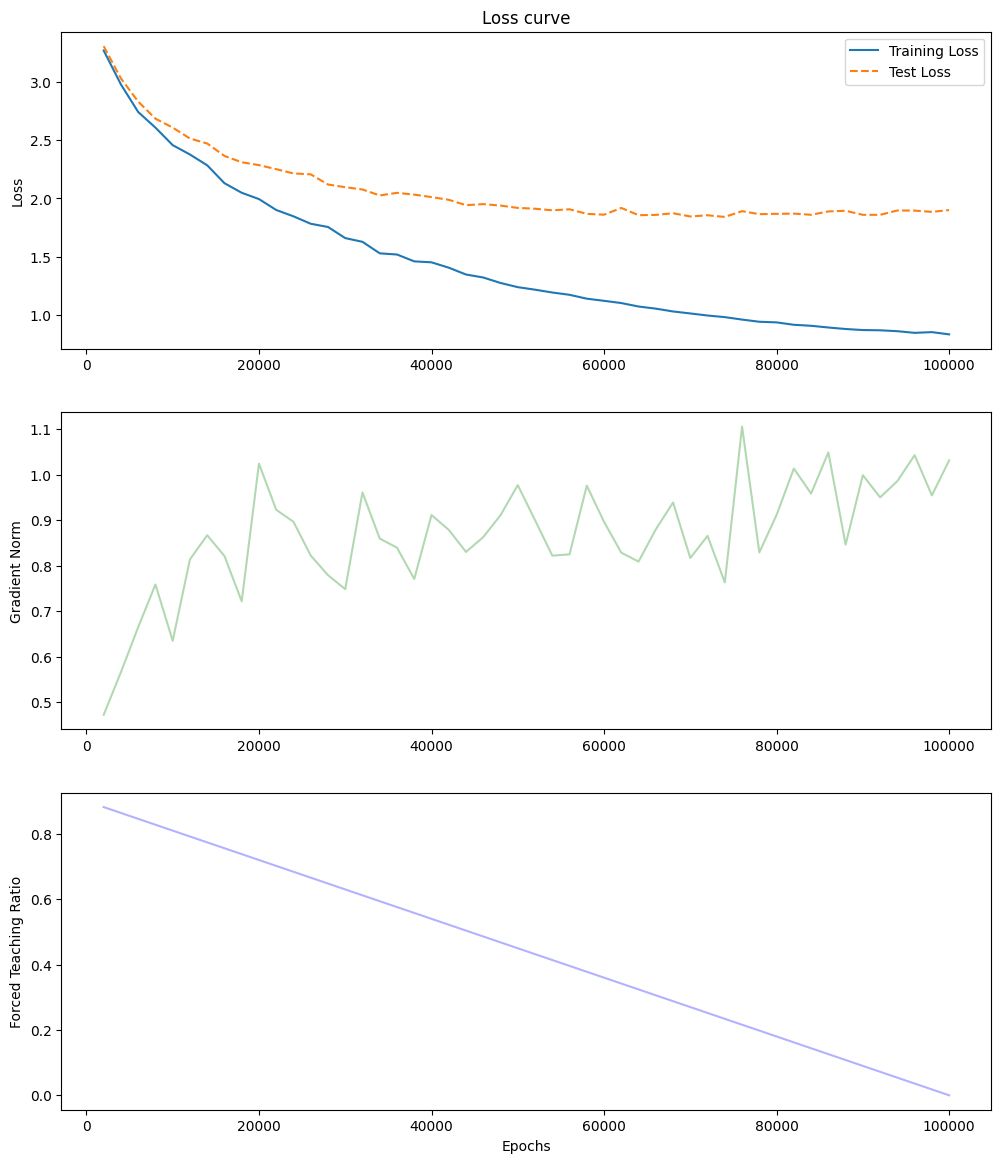

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Plot training and test loss on the first subplot
ax1.plot(epoch_count, train_loss_values, label='Training Loss')
ax1.plot(epoch_count, test_loss_values, label='Test Loss', linestyle='--')
ax3.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss curve')
ax1.legend(loc='upper right')

# Plot gradient norm on the second subplot
ax2.plot(epoch_count, gradients_norm, 'g', alpha=0.3)
ax3.set_xlabel('Epochs')
ax2.set_ylabel('Gradient Norm')

# Plot forced teaching ratio decay on the third subplot
ax3.plot(epoch_count, ratio_values, 'b', alpha=0.3)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Forced Teaching Ratio')

plt.show()

In [17]:
### Use model ###

print(model.translate('I\'m very happy.'))
print(model.translate('He\'s very sad.'))
print(model.translate('That man is wearing a white shirt.'))
print(model.translate('He\'s afraid of spiders.'))
print(model.translate('He\'s going home to his wife.'))
print(model.translate('Those guys are walking to work.'))
print(model.translate('I\'m not going with you today.'))
print(model.translate('My girlfriend will not come over tomorrow.'))

Ik ben heel blij.
Hij is heel..
Die man man er een een is een rode.
Hij is bang dat hij op <unk>..
Hij gaat naar zijn vrouw vrouw vrouw.
Die kinderen gaan het om werk te te.. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ik ga niet meer met met je naar huis.
Mijn vriendin zal niet komen niet zal komen te.
